#**TASK 1 🍽  **Automated Kitchen Item Categorization Model:****
![PIC](https://entrackr.com/storage/2023/02/Cookr.jpg)

---------------------

**When the cook adds an item to their kitchen, it should be automatically categorized into multiple categories.**

-----------------------

.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd /content/drive/MyDrive/Dataset/

/content/drive/MyDrive/Dataset


In [7]:
%ls

Category.h5  tensorflow_hub/  test/  train/  validation/


In [9]:
import os


In [10]:
for dirpath, dirnames, filenames in os.walk('/content/drive/MyDrive/Dataset'):
  print(f'{len(dirnames)}, {len(filenames)}, {dirpath}')

5, 1, /content/drive/MyDrive/Dataset
20, 0, /content/drive/MyDrive/Dataset/test
0, 14, /content/drive/MyDrive/Dataset/test/PaaniPuri
0, 29, /content/drive/MyDrive/Dataset/test/Pizza
0, 34, /content/drive/MyDrive/Dataset/test/Kulfi
0, 61, /content/drive/MyDrive/Dataset/test/KaathiRolls
0, 64, /content/drive/MyDrive/Dataset/test/KadaiPaneer
0, 30, /content/drive/MyDrive/Dataset/test/Samosa
0, 50, /content/drive/MyDrive/Dataset/test/MasalaDosa
0, 46, /content/drive/MyDrive/Dataset/test/Pakode
0, 34, /content/drive/MyDrive/Dataset/test/PavBhaji
0, 58, /content/drive/MyDrive/Dataset/test/Momos
0, 62, /content/drive/MyDrive/Dataset/test/Chai
0, 106, /content/drive/MyDrive/Dataset/test/Burger
0, 57, /content/drive/MyDrive/Dataset/test/Dhokla
0, 65, /content/drive/MyDrive/Dataset/test/Jalebi
0, 68, /content/drive/MyDrive/Dataset/test/ButterNaan
0, 65, /content/drive/MyDrive/Dataset/test/FriedRice
0, 60, /content/drive/MyDrive/Dataset/test/DalMakhani
0, 94, /content/drive/MyDrive/Dataset/test/C

#**Data Preprocessing and Directory Setup**

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = 'Dataset/train/'
test_dir = 'Dataset/validation/'

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training Images : ")
train_data = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode='categorical')
print("Testing Images : ")
test_data = test_datagen.flow_from_directory(test_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical')

Training Images : 
Found 4551 images belonging to 20 classes.
Testing Images : 
Found 580 images belonging to 20 classes.


In [2]:
import datetime

def create_tb_callback(dir_name, exp_name):
  log_dir = dir_name + '/' + exp_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f'Saving TensorBoard log files to {log_dir}')
  return tensorboard_callback

#**Model Architecture Selection:  " EfficientNet " and " ResNet "**

In [3]:
efficient_net = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'
resnet = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'

In [4]:
import tensorflow as tf
from tensorflow.keras import layers

In [5]:
import tensorflow_hub as hub

In [6]:
def create_model(model_url,num_classes=20):
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,))

  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation='softmax', name='output_layer')
  ])

  return model

In [7]:
resnet_model = create_model(resnet,
                            num_classes=train_data.num_classes)

In [8]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 20)                40980     
                                                                 
Total params: 23605780 (90.05 MB)
Trainable params: 40980 (160.08 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [9]:
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])

#**MODEL TRAINING AND EVALUATION**

In [10]:
resnet_history = resnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tb_callback(dir_name='tensorflow_hub',
                                                                exp_name='resnet50V2'
                                                                )])

Saving TensorBoard log files to tensorflow_hub/resnet50V2/20240301-233028
Epoch 1/5
143/143 [==============================] - 346s 2s/step - loss: 1.2506 - accuracy: 0.6432 - val_loss: 1.0529 - val_accuracy: 0.6879
Epoch 2/5
143/143 [==============================] - 337s 2s/step - loss: 0.5748 - accuracy: 0.8425 - val_loss: 0.9420 - val_accuracy: 0.7224
Epoch 3/5
143/143 [==============================] - 346s 2s/step - loss: 0.4107 - accuracy: 0.8921 - val_loss: 0.8691 - val_accuracy: 0.7672
Epoch 4/5
143/143 [==============================] - 356s 2s/step - loss: 0.3133 - accuracy: 0.9220 - val_loss: 0.9080 - val_accuracy: 0.7569
Epoch 5/5
143/143 [==============================] - 350s 2s/step - loss: 0.2424 - accuracy: 0.9457 - val_loss: 0.9130 - val_accuracy: 0.7517


In [11]:
import matplotlib.pyplot as plt


def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))
  plt.figure(figsize=(20,6))
  plt.subplot(1,2,1)
  plt.plot(epochs,loss, label='training_loss')
  plt.plot(epochs,val_loss, label='val_loss')

  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs, acc, label='training_accuracy')
  plt.plot(epochs, val_acc, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

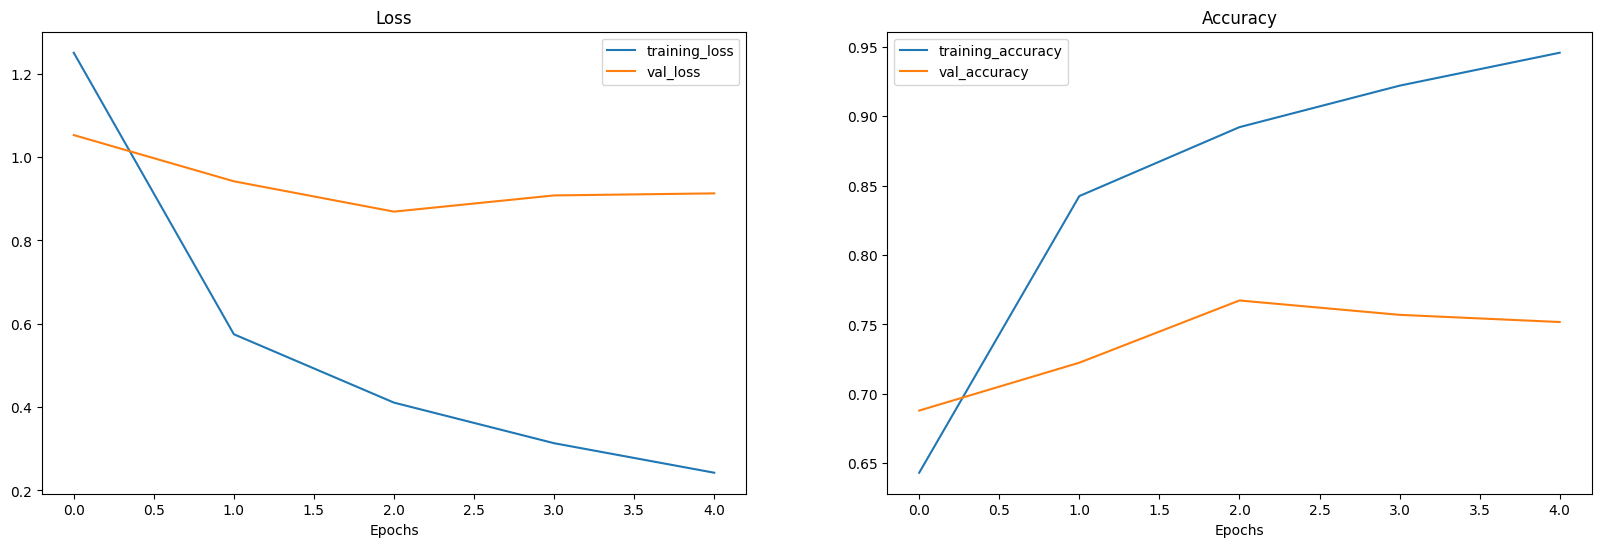

In [12]:
plot_loss_curves(resnet_history)

In [13]:
efficientnet_model = create_model(efficient_net,
                            num_classes=train_data.num_classes)

In [14]:
efficientnet_model.compile(loss='categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])

In [15]:
efficientnet_history = efficientnet_model.fit(train_data,
                                  epochs=3,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tb_callback(dir_name='tensorflow_hub',
                                                                exp_name='efficientnetb0'
                                                                )])

Saving TensorBoard log files to tensorflow_hub/efficientnetb0/20240302-000006
Epoch 1/3
143/143 [==============================] - 241s 2s/step - loss: 1.2988 - accuracy: 0.7106 - val_loss: 0.9368 - val_accuracy: 0.7603
Epoch 2/3
143/143 [==============================] - 225s 2s/step - loss: 0.5442 - accuracy: 0.8833 - val_loss: 0.7405 - val_accuracy: 0.7879
Epoch 3/3
143/143 [==============================] - 228s 2s/step - loss: 0.4058 - accuracy: 0.9075 - val_loss: 0.6544 - val_accuracy: 0.8293


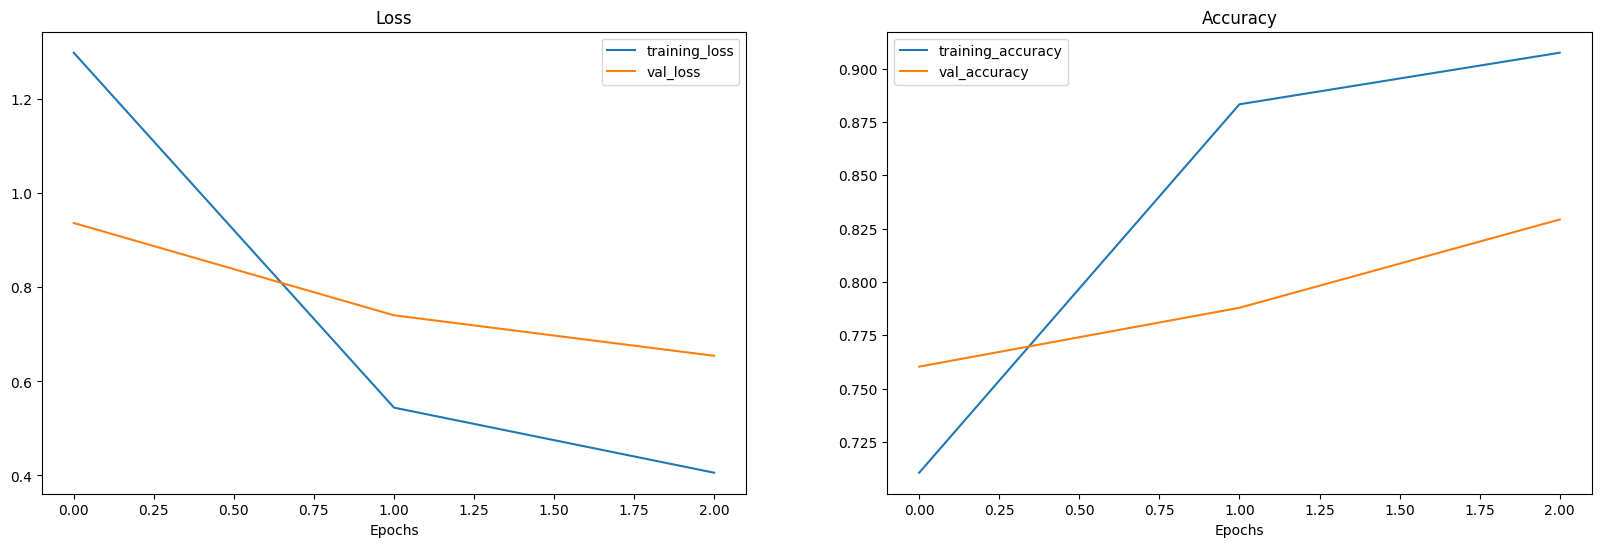

In [16]:
plot_loss_curves(efficientnet_history)

In [17]:
efficientnet_model.evaluate(test_data)

19/19 [==============================] - 25s 1s/step - loss: 0.6544 - accuracy: 0.8293


[0.65440833568573, 0.8293103575706482]

In [18]:
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['Burger' 'ButterNaan' 'Chai' 'Chapatti' 'CholeBhature' 'DalMakhani'
 'Dhokla' 'FriedRice' 'Idli' 'Jalebi' 'KaathiRolls' 'KadaiPaneer' 'Kulfi'
 'MasalaDosa' 'Momos' 'PaaniPuri' 'Pakode' 'PavBhaji' 'Pizza' 'Samosa']


----------------------------------------------

.
#**PREDICTING AND CATEGORIZING THE FOOD ITEM**
---------------------------------------------

In [19]:
def load_and_prep_image(filename, img_shape=224):

  img = tf.io.read_file(filename)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.resize(img, size = [img_shape, img_shape])
  img = img/255.
  return img


In [65]:
def pred_and_plot(model, filename, class_names):

  img = load_and_prep_image(filename)
  pred = model.predict(tf.expand_dims(img, axis=0))

  if len(pred[0]) > 1:
    pred_class = class_names[pred.argmax()]
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])]

 

  plt.imshow(img)
  plt.title(f"ADDED ITEM:  {pred_class}")
  plt.axis(False)
  return pred_class
  



>> ADD ITEM TO THE KITCHEN

1/1 [==============================] - 0s 298ms/step
Idli


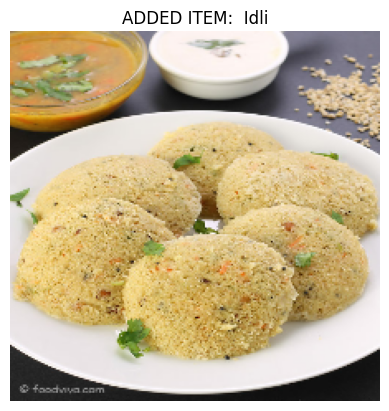

In [66]:
print("\n>> ADD ITEM TO THE KITCHEN\n")
food=pred_and_plot(efficientnet_model, "i1.jpg", class_names)
print(food)

In [88]:
menu=['Burger','ButterNaan','Chai','Chapatti','CholeBhature','DalMakhani','Dhokla','FriedRice','Idli','Jalebi','KaathiRolls','KadaiPaneer','Kulfi','MasalaDosa','Momos','PaaniPuri','Pakode','PavBhaji','Pizza','Samosa']

ing=["sliced onion,cheese slices,garam masala powder,oil,ginger paste,burger buns,tomato ketchup,garlic paste,sliced tomato,chilli,salt,butter,patty,lettuce",
      "Flour,Honey,Yeast,Baking powder,Butter,Salt,Yogurt,Egg",
      "black tea,milk,cardamom powder,grated ginger,sugar",
      "wheat flour,ghee,oil,water,Salt",
      "chickpeas,onion,tomato,coriander powder,garlic,turmeric,chana masala powder,cumin,ginger,onion paste,Salt,garam masala,chilli powder",
      "red kidney beans,red chilli powder,butter,onion,tomato puree,cream,ginger paste,water,Salt,ginger,refined oil,green chilli,garam masala powder,urad dal,garlic paste",
      "gram flour,sugar,Salt,oil,mustard seeds,water,lemon juice,baking soda,curry leaves",
      "rice,butter,Carrots,onions,green onions,peas,oil,soy sauce,Eggs,Garlic",
      "basmati rice,fenugreek seeds,sesame oil,urad dal,Salt,water",
      "flour,curd,ghee,sugar,saffron,green cardamom,corn flour,baking soda,oil,water,rose essence",
      "Chicken,Yogurt,chilli powder,turmeric,cumin,coriander powder,lemon juice,Salt",
      "Paneer,capsicum,onion,Tomatoes,ginger paste,chilli powder,coriander powder,cumin,fennel seeds,peppercorns,cinnamon,cloves,fenugreek seeds,turmeric powder,coriander powder,Garam masala,Kasuri methi,oil,Salt",
      "Milk,Sugar,Condensed milk,Cardamom powder,Chopped nuts,Saffron strands",
      "rice,urad dal,fenugreek seeds,potatoes,onion,green chilli,mustard seeds,cumin,Salt,water",
      "flour,water,cabbage,Carrots,onions,Garlic,ginger paste,green onions,soy sauce,sesame oil,Salt,Black pepper,oil"  ,
      "Rava,water,mint leaves,coriander leaves,green chilli,Tamarind pulp,potatoes,chickpeas,Salt,cumin,Chaat masala,puris",
      "Gram flour,Potatoes,Onions,Green chilies,ginger,coriander powder,turmeric,red chilli powder,garam masala,Baking soda,Oil",
      "Potatoes,Peas,Carrots,Capsicum,Tomatoes,Onions,Garlic,Pav bhaji masala,chilli powder,Turmeric powder,Butter,Pav",
      "Pizza dough,Pizza sauce,Mozzarella cheese,Bell peppers,Onions,Tomatoes,Olives,Mushrooms,Oregano,Basi",
      "Potatoes,Peas,Carrots,coriander powder,cumin powder,garam masala,chilli powder,Ginger,Garlic"
]

cuisine=["American","Indian","Indian","Indian","Punjabi","Punjabi","Gujarati","Chinese","South Indian","Iranian","Bengali","Indian","Indian","South Indian","Chinese","North India","Indian","Indian","Italian","Portuguese"]

nonveg=["Chicken","Mutton","Beef","Pork","Fish","Prawns","Crab","Lobster","Duck","Turkey","Quail","Venison","Rabbit","Squid","Octopus"]

protein=["Eggs","milk","Yoghurt","chickpeas"]

print()
print(food +": ",end="")
x=menu.index(food)
print(cuisine[x]+" ",end="")
l=ing[x].split(",")
#print(l)
for i in l:
    if i in protein:
        print("Protein-Rich ",end="")
        break
f=0
for i in l:
    if i in nonveg:
        print("NonVegetarian ",end="")
        f=1
        break
if f==0:
    print("Vegetarian ",end="")

if "sugar" not in l:
    print("Diabetic-Friendly ",end="")
print("\n")



Idli: South Indian Vegetarian Diabetic-Friendly 



In [89]:
name1=input("Enter new Food item: ")
y=""
for i in range(int(input("Enter no. of ingredients: "))):
    l=input("Enter ingredient: ")
    y+=l+","
y=y[:-1]
z=0
ct=0
a=0
for i in ing:
    stri=i.split(",")
    for j in stri:
        if j in y.split(","):
            ct+=1
    if ct>z:
        z=ct
        a=i
    ct=0

print()
print(name1 +": ",end="")
x=ing.index(a)
q1=cuisine[x]
print(cuisine[x]+" ",end="")
l=ing[x].split(",")
for i in l:
    if i in protein:
        print("Protein-Rich ",end="")
        break
f=0
for i in l:
    if i in nonveg:
        print("NonVegetarian ",end="")
        f=1
        break
if f==0:
    print("Vegetarian ",end="")

if "sugar" not in l:
    print("Diabetic-Friendly ",end="")
print("\n")


Paneer: Indian Vegetarian Diabetic-Friendly 

